# Exercises - Discrete Anomaly Detection

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


/var/folders/2g/_40bymd11_x47n42bls8ypmr0000gn/T/ipykernel_97151/447971755.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [4]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [5]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [6]:
df.request_method.value_counts().head()


GET    13978
Name: request_method, dtype: int64

In [7]:
df.request_method.value_counts(normalize=True).head()

GET    1.0
Name: request_method, dtype: float64

In [8]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,)

In [9]:
rm_df = value_counts_and_frequencies(df.request_method)
rm_df.head()

,count,proba
GET,13978,1.0


<AxesSubplot:>

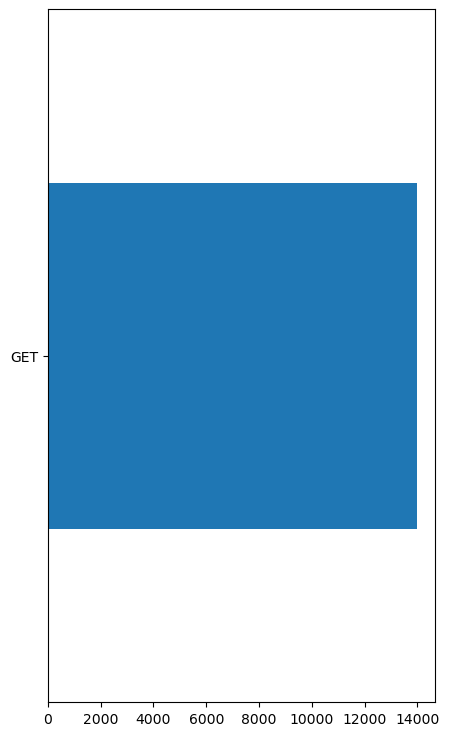

In [10]:
rm_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

***Takeaway***

- There are no anomalys, and no value in moving forward with this feature, because there is only one request method.

In [11]:
df.request_path.value_counts().head()

/api/v1/sales?page=2    709
/api/v1/items           464
/api/v1/items?page=2    291
/api/v1/items?page=3    219
/api/v1/stores          162
Name: request_path, dtype: int64

In [12]:
df.request_path.value_counts(normalize=True).head()

/api/v1/sales?page=2    0.050723
/api/v1/items           0.033195
/api/v1/items?page=2    0.020818
/api/v1/items?page=3    0.015667
/api/v1/stores          0.011590
Name: request_path, dtype: float64

In [13]:
def value_counts_and_frequencies2(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [14]:
rp_df = value_counts_and_frequencies2(df.request_path)
rp_df.head()

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590


<AxesSubplot:>

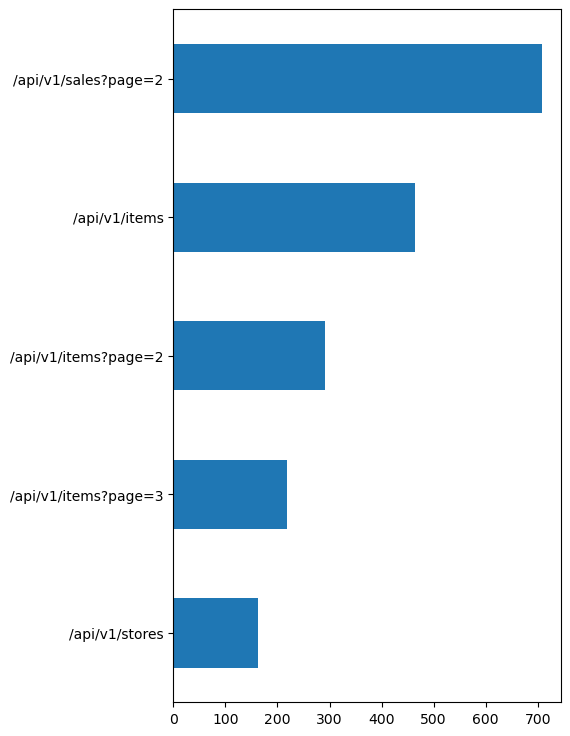

In [15]:
rp_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [16]:
status_given_rp = (
    df.groupby('request_path')
    .ip.value_counts(normalize=True)
    .rename('proba_status_given_rp')
    .reset_index()
)
status_given_rp


,request_path,ip,proba_status_given_rp
0,/,97.105.19.58,0.887850
1,/,68.201.219.223,0.028037
2,/,72.181.105.81,0.028037
3,/,173.173.113.51,0.009346
4,/,3.92.201.136,0.009346
...,...,...,...
815,/favicon.ico,52.87.230.102,0.038462
816,/favicon.ico,52.90.165.200,0.038462
817,/favicon.ico,54.145.52.184,0.038462
818,/favicon.ico,70.121.214.34,0.038462


In [17]:
status_given_rp[status_given_rp.proba_status_given_rp < .1]

,request_path,ip,proba_status_given_rp
1,/,68.201.219.223,0.028037
2,/,72.181.105.81,0.028037
3,/,173.173.113.51,0.009346
4,/,3.92.201.136,0.009346
5,/,35.175.171.137,0.009346
...,...,...,...
815,/favicon.ico,52.87.230.102,0.038462
816,/favicon.ico,52.90.165.200,0.038462
817,/favicon.ico,54.145.52.184,0.038462
818,/favicon.ico,70.121.214.34,0.038462


In [87]:
df[df.ip == '72.181.113.170']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:12:07,72.181.113.170,GET,/api/v1/items,HTTP/1.1,200,3561.0,python-requests/2.21.0,0.003396
2019-04-17 02:18:07,72.181.113.170,GET,/,HTTP/1.1,200,42.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.00004
2019-04-17 02:18:07,72.181.113.170,GET,/favicon.ico,HTTP/1.1,200,162.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000154
2019-04-17 02:48:27,72.181.113.170,GET,/api/v1/sales,HTTP/1.1,200,493905.0,python-requests/2.21.0,0.471025
2019-04-17 02:48:28,72.181.113.170,GET,/api/v1/sales?page=2,HTTP/1.1,200,494819.0,python-requests/2.21.0,0.471896
...,...,...,...,...,...,...,...,...
2019-04-17 03:52:00,72.181.113.170,GET,/api/v1/sales?page=179,HTTP/1.1,200,511963.0,python-requests/2.21.0,0.488246
2019-04-17 03:52:02,72.181.113.170,GET,/api/v1/sales?page=180,HTTP/1.1,200,510788.0,python-requests/2.21.0,0.487125
2019-04-17 03:52:04,72.181.113.170,GET,/api/v1/sales?page=181,HTTP/1.1,200,510317.0,python-requests/2.21.0,0.486676


***Takeaways***

- This particular user is accessing python and mozilla agents, all on the same day and at between the early hours of 2-4am.

In [18]:
df.http_version.value_counts().head()

HTTP/1.1    13978
Name: http_version, dtype: int64

- There is only one http version and therefore, zero anomalys.

In [19]:
df.status_code.value_counts().head()

200    13960
499       16
301        2
Name: status_code, dtype: int64

In [20]:
df.status_code.value_counts(normalize=True).head()

200    0.998712
499    0.001145
301    0.000143
Name: status_code, dtype: float64

In [21]:
def value_counts_and_frequencies3(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [22]:
sc_df = value_counts_and_frequencies3(df.status_code)
sc_df.head()

,count,proba
200,13960,0.998712
499,16,0.001145
301,2,0.000143


<AxesSubplot:>

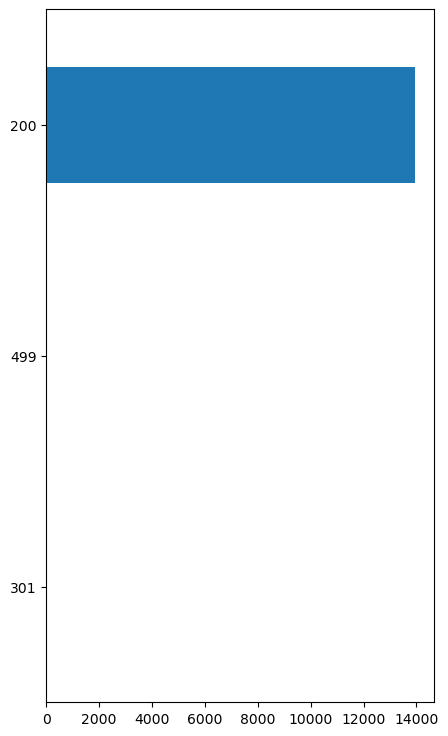

In [23]:
sc_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [88]:
status_given_sc = (
    df.groupby('status_code')
    .ip.value_counts(normalize=True)
    .rename('proba_status_given_status_code')
    .reset_index()
)
status_given_sc

,status_code,ip,proba_status_given_status_code
0,200,97.105.19.58,0.858524
1,200,173.173.113.51,0.075860
2,200,72.181.113.170,0.043768
3,200,72.181.105.81,0.017622
4,200,24.26.242.9,0.001504
5,200,68.201.219.223,0.001504
6,200,35.175.171.137,0.000143
7,200,52.87.230.102,0.000143
8,200,70.121.214.34,0.000143
9,200,3.88.129.158,0.000072


In [89]:
status_given_sc[status_given_sc.ip == '95.31.16.121']

,status_code,ip,proba_status_given_status_code
20,301,95.31.16.121,0.5


In [90]:
df[df.ip == '95.31.16.121']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005.0,python-requests/2.21.0,0.000958


***Takeaways***

- The 301s and 499s are a little suspicious and probably warrants some more investigation. However, this particular user does not appear to be concerning.

In [33]:
df['size'] = df['size'].astype(object)

In [34]:
df.dtypes

ip                 object
request_method     object
request_path       object
http_version       object
status_code        object
size               object
user_agent         object
size_mb           float64
dtype: object

In [38]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495.0,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561.0,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103.0,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003.0,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963.0,python-requests/2.21.0,0.488246


In [41]:
df['size'].value_counts().head()

494819.0    705
3561.0      548
3659.0      291
1328.0      229
1787.0      219
Name: size, dtype: int64

In [43]:
df['size'].value_counts(normalize=True).head()


494819.0    0.050436
3561.0      0.039204
3659.0      0.020818
1328.0      0.016383
1787.0      0.015667
Name: size, dtype: float64

In [44]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [45]:
size_df = value_counts_and_frequencies(df['size'])
size_df.head()

,count,proba
494819.0,705,0.050436
3561.0,548,0.039204
3659.0,291,0.020818
1328.0,229,0.016383
1787.0,219,0.015667


<AxesSubplot:>

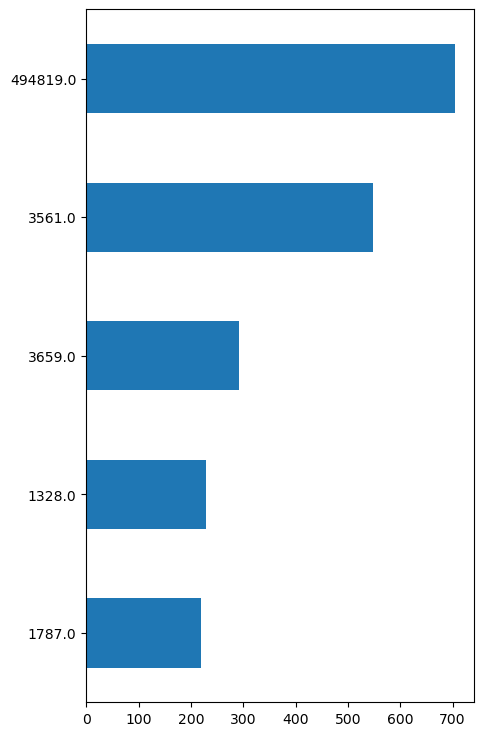

In [46]:
size_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [91]:
status_given_size = (
    df.groupby('size')
    .ip.value_counts(normalize=True)
    .rename('proba_status_given_size')
    .reset_index()
)
status_given_size

,size,ip,proba_status_given_size
0,0.0,97.105.19.58,0.875000
1,0.0,72.181.113.170,0.125000
2,42.0,97.105.19.58,0.887850
3,42.0,68.201.219.223,0.028037
4,42.0,72.181.105.81,0.028037
...,...,...,...
744,513736.0,173.173.113.51,0.076923
745,513736.0,72.181.113.170,0.046154
746,513736.0,72.181.105.81,0.015385
747,1153005.0,95.31.18.119,1.000000


In [49]:
status_given_size[status_given_size.ip != '97.105.19.58']

,size,ip,proba_status_given_size
1,0.0,72.181.113.170,0.125000
3,42.0,68.201.219.223,0.028037
4,42.0,72.181.105.81,0.028037
5,42.0,173.173.113.51,0.009346
6,42.0,3.92.201.136,0.009346
...,...,...,...
742,513313.0,72.181.105.81,0.015625
744,513736.0,173.173.113.51,0.076923
745,513736.0,72.181.113.170,0.046154
746,513736.0,72.181.105.81,0.015385


In [54]:
df[df.ip == '95.31.18.119']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005.0,python-requests/2.21.0,1.099591


***Takeaways***

- Nothing particularly useful about the size, except that the majority of the users have larger size amounts and are associated with the 200 status code.

In [55]:
df.user_agent.value_counts().head()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Name: user_agent, dtype: int64

In [56]:
df.user_agent.value_counts(normalize=True).head()

python-requests/2.21.0                                                                                                       0.858850
python-requests/2.20.1                                                                                                       0.136715
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000501
Name: user_agent, dtype: float64

In [57]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [58]:
ua_df = value_counts_and_frequencies(df.user_agent)
ua_df.head()

,count,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501


<AxesSubplot:>

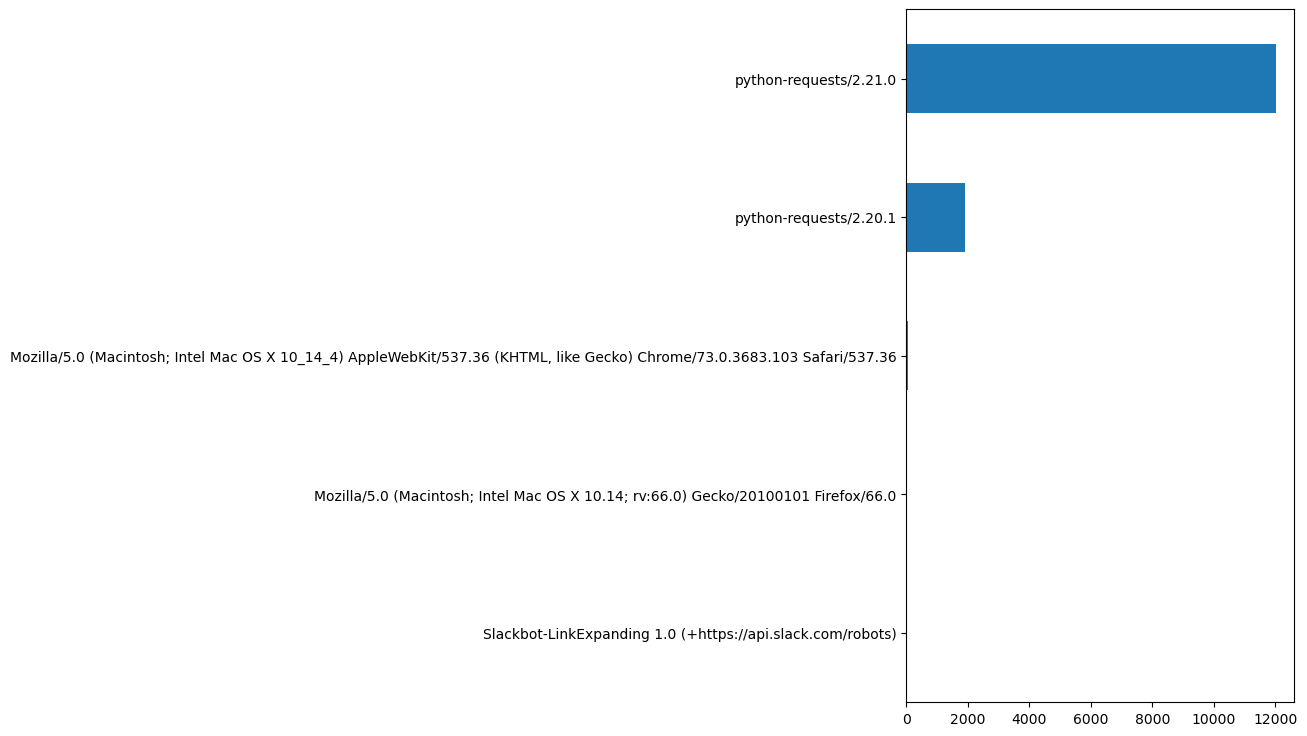

In [59]:
ua_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [62]:
status_given_ua = (
    df.groupby('user_agent')
    .ip.value_counts(normalize=True)
    .rename('proba_status_given_ua')
    .reset_index()
)
status_given_ua

,user_agent,ip,proba_status_given_ua
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,72.181.105.81,1.000000
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,70.121.214.34,1.000000
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.181.113.170,0.500000
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,97.105.19.58,0.500000
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,97.105.19.58,0.764706
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,72.181.105.81,0.235294
6,Python-urllib/3.7,97.105.19.58,1.000000
7,Slackbot 1.0 (+https://api.slack.com/robots),34.207.64.242,0.166667
8,Slackbot 1.0 (+https://api.slack.com/robots),34.229.70.250,0.166667
9,Slackbot 1.0 (+https://api.slack.com/robots),35.174.209.2,0.166667


In [64]:
status_given_ua[status_given_ua.user_agent == 'Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)']

,user_agent,ip,proba_status_given_ua
13,Slackbot-LinkExpanding 1.0 (+https://api.slack...,35.175.171.137,0.285714
14,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.88.129.158,0.142857
15,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.92.201.136,0.142857
16,Slackbot-LinkExpanding 1.0 (+https://api.slack...,52.87.230.102,0.142857
17,Slackbot-LinkExpanding 1.0 (+https://api.slack...,52.91.30.150,0.142857
18,Slackbot-LinkExpanding 1.0 (+https://api.slack...,54.172.14.223,0.142857


In [65]:
df[df.ip == '35.175.171.137']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 21:22:22,35.175.171.137,GET,/,HTTP/1.1,200,42.0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040
2019-04-16 21:38:57,35.175.171.137,GET,/api/v1/items,HTTP/1.1,200,3561.0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396


***Takeaways***

- The slackbot user agent might be a concern because this could be a hacker or some sort of bot trying to gain unauthorized access. The late evening times are a little concerning as well, but some students might be working that late at night.

In [67]:
df['size_mb'] = df['size_mb'].astype(object)

In [68]:
df.dtypes

ip                object
request_method    object
request_path      object
http_version      object
status_code       object
size              object
user_agent        object
size_mb           object
dtype: object

In [69]:
df['size_mb'].value_counts().head()

0.471896    705
0.003396    548
0.003489    291
0.001266    229
0.001704    219
Name: size_mb, dtype: int64

In [71]:
df['size_mb'].value_counts(normalize=True).head()

0.471896    0.050436
0.003396    0.039204
0.003489    0.020818
0.001266    0.016383
0.001704    0.015667
Name: size_mb, dtype: float64

In [72]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [73]:
sm_df = value_counts_and_frequencies(df['size_mb'])
sm_df.head()

,count,proba
0.471896,705,0.050436
0.003396,548,0.039204
0.003489,291,0.020818
0.001266,229,0.016383
0.001704,219,0.015667


<AxesSubplot:>

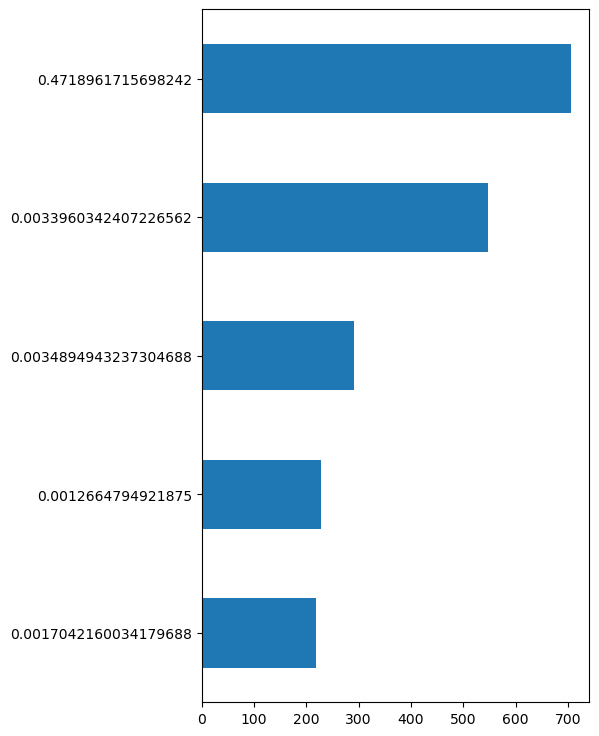

In [74]:
sm_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [76]:
status_given_sm = (
    df.groupby('size_mb')
    .ip.value_counts(normalize=True)
    .rename('proba_status_given_sm')
    .reset_index()
)
status_given_sm

,size_mb,ip,proba_status_given_sm
0,0.000000,97.105.19.58,0.875000
1,0.000000,72.181.113.170,0.125000
2,0.000040,97.105.19.58,0.887850
3,0.000040,68.201.219.223,0.028037
4,0.000040,72.181.105.81,0.028037
...,...,...,...
744,0.489937,173.173.113.51,0.076923
745,0.489937,72.181.113.170,0.046154
746,0.489937,72.181.105.81,0.015385
747,1.099591,95.31.18.119,1.000000


In [80]:
status_given_sm[status_given_sm.proba_status_given_sm < .01]

,size_mb,ip,proba_status_given_sm
5,0.000040,173.173.113.51,0.009346
6,0.000040,3.92.201.136,0.009346
7,0.000040,35.175.171.137,0.009346
8,0.000040,52.91.30.150,0.009346
9,0.000040,70.121.214.34,0.009346
10,0.000040,72.181.113.170,0.009346
36,0.001266,45.23.250.16,0.004367
48,0.003396,3.88.129.158,0.001825
49,0.003396,35.175.171.137,0.001825
70,0.471025,52.87.230.102,0.004785


In [86]:
df[df.ip == '72.181.105.81']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 22:01:52,72.181.105.81,GET,/api/v1/items,HTTP/1.1,200,3561.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.003396
2019-04-16 22:01:52,72.181.105.81,GET,/favicon.ico,HTTP/1.1,200,162.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
2019-04-16 22:01:53,72.181.105.81,GET,/api/v1/,HTTP/1.1,200,162.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
2019-04-16 22:01:53,72.181.105.81,GET,/favicon.ico,HTTP/1.1,200,162.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
2019-04-16 22:02:42,72.181.105.81,GET,/api/v1/,HTTP/1.1,200,162.0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154
...,...,...,...,...,...,...,...,...
2019-04-17 02:18:20,72.181.105.81,GET,/api/v1/sales?page=179,HTTP/1.1,200,511963.0,python-requests/2.21.0,0.488246
2019-04-17 02:18:22,72.181.105.81,GET,/api/v1/sales?page=180,HTTP/1.1,200,510788.0,python-requests/2.21.0,0.487125
2019-04-17 02:18:24,72.181.105.81,GET,/api/v1/sales?page=181,HTTP/1.1,200,510317.0,python-requests/2.21.0,0.486676


***Takeaways***

- There are miltiple successful attempts at late hours and early morning, but small mb sizes. This might warrant further investigation into this particular user and simply asking the question of why they are accessing the codeup curriculum this early in the morning. This might also be an indicator of a student who might need help with time management or another issue with their sleep or other dilemmas that they could need help with.